# Semantic Analysis Over Mobby Dick Lecture

About me:
I am Jeison Robbles Arias, a very enthucistic person focused on improving skills, education growing and difunding engineering.
Can Fallow Me through:
- [Medium](https://medium.com/@roblesjeison)
- [Linkedin](https://www.linkedin.com/in/jeison-robles-arias-6ab8a9ba/)
- [GitHub](https://github.com/JeisonRobles)

<br>**Notebook focus:**</br></br>
This note book steps over the basics about document preprocesing, embeding creation, semantic spaces and clustering for insight extraction.

Along this analysis I use usual tools and strategies in a common basic pipeline to extract information about documents. Information that  can be used as a RAG file for LLM and Agentic Systems that lather I'll be using in  further publications.

The document will be structured as follows:

1. [Basic knowledge and strategy](#basics)
2. [Loading sources](#loading-sources)
3. [Preprocesing](#preprocesing)
4. [Vectorizing](#vectorizing)
5. [Neighbors analysis](#neighbors-analysis)
6. [Exploring Visuals](#exploring-visuals)

## Basics

## Loading sources

In [1]:
import sys
from pathlib import Path

# Notebook-safe project root (assumes notebook is in /notebooks)
PROJECT_ROOT = Path.cwd().parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: /Users/jeisonroblesarias/Documents/ODSC_2026/moby-embeddings-from-stratch


In [2]:
# =======================
# Setting paths
DATA_RAW = PROJECT_ROOT / "data" / "raw" / "mobydick.txt"
OUTPUTS = PROJECT_ROOT / "outputs"
OUTPUTS.mkdir(exist_ok=True)
DATA_RAW, OUTPUTS

(PosixPath('/Users/jeisonroblesarias/Documents/ODSC_2026/moby-embeddings-from-stratch/data/raw/mobydick.txt'),
 PosixPath('/Users/jeisonroblesarias/Documents/ODSC_2026/moby-embeddings-from-stratch/outputs'))

In [3]:
# =======================
# Loading documents and inspecting
with open(DATA_RAW, "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Chars:", len(raw_text))
print(raw_text[:1000])


Chars: 1238242
The Project Gutenberg eBook of Moby Dick; Or, The Whale
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Moby Dick; Or, The Whale

Author: Herman Melville

Release date: July 1, 2001 [eBook #2701]
                Most recently updated: September 11, 2025

Language: English

Credits: Daniel Lazarus, Jonesey, and David Widger


*** START OF THE PROJECT GUTENBERG EBOOK MOBY DICK; OR, THE WHALE ***




MOBY-DICK;

or, THE WHALE.

By Herman Melville



CONTENTS

ETYMOLOGY.

EXTRACTS (Supplied by a Sub-Sub-Librarian).

CHAPTER 1. Loomings.

CHAPTER 2. The Carpet-Bag.

CHAPTER 3

## Preprocesing

In [4]:
from src.preprocess import PreprocessConfig, make_paragraph_dataset
from src.vectorize_tfidf import TfidfConfig, build_tfidf_matrix
from src.similarity import top_k_similar_rows
from src.reduce_dim import pca_2d
from src.viz import plot_embeddings_2d, plot_embeddings_2d_Clusters

import pandas as pd

In [5]:
cfg = PreprocessConfig(
    min_paragraph_chars=200,  # increase if you want fewer, richer paragraphs
    lowercase=True
)

rows = make_paragraph_dataset(raw_text, cfg)
df = pd.DataFrame(rows, columns=["paragraph_id", "raw_text", "clean_text"])

print("Paragraphs:", len(df))
df.head(5)

Paragraphs: 1567


,paragraph_id,raw_text,clean_text
0,0,"This text is a combination of etexts, one from...",this text is a combination of etexts one from ...
1,1,"The pale Usher—threadbare in coat, heart, body...",the pale usher threadbare in coat heart body a...
2,2,"“While you take in hand to school others, and ...",while you take in hand to school others and to...
3,3,It will be seen that this mere painstaking bur...,it will be seen that this mere painstaking bur...
4,4,"So fare thee well, poor devil of a Sub-Sub, wh...",so fare thee well poor devil of a sub sub whos...


In [6]:
df["char_len"] = df["clean_text"].str.len()
df["word_len"] = df["clean_text"].str.split().str.len()
df[["char_len", "word_len"]].describe()

,char_len,word_len
count,1567.00000,1567.000000
mean,684.92023,127.462668
std,479.11573,89.246217
min,200.00000,32.000000
25%,347.00000,65.000000
50%,541.00000,101.000000
75%,884.00000,163.000000
max,3466.00000,734.000000


In [7]:
i = 0
print("RAW:\n", df.loc[i, "raw_text"][:700])
print("\nCLEAN:\n", df.loc[i, "clean_text"][:700])

RAW:
 This text is a combination of etexts, one from the now-defunct ERIS
project at Virginia Tech and one from Project Gutenberg’s archives. The
proofreaders of this version are indebted to The University of Adelaide
Library for preserving the Virginia Tech version. The resulting etext
was compared with a public domain hard copy version of the text.

CLEAN:
 this text is a combination of etexts one from the now defunct eris project at virginia tech and one from project gutenberg s archives the proofreaders of this version are indebted to the university of adelaide library for preserving the virginia tech version the resulting etext was compared with a public domain hard copy version of the text


## Vectorizing

Using TF-IDF (Term Frequency - Inverse Document Frequency)

In [8]:
tfidf_cfg = TfidfConfig(
    min_df=3,
    max_df=0.9,
    ngram_range=(1, 2),     # unigrams + bigrams makes it feel “semantic”
    stop_words="english",
    sublinear_tf=True,
    norm="l2"               # important: L2 normalization makes cosine meaningful
)

X, vectorizer = build_tfidf_matrix(df["clean_text"].tolist(), tfidf_cfg)

print("TF-IDF shape:", X.shape)  # (num_paragraphs, num_terms)


TF-IDF shape: (1567, 6838)


## Neighbors Analysis

In [9]:
query_idx = 10  # change this
neighbors = top_k_similar_rows(X, query_idx, k=5)

print("QUERY PARAGRAPH:\n")
print(df.loc[query_idx, "raw_text"][:600], "...\n")

print("TOP NEIGHBORS:\n")
for idx, score in neighbors:
    print(f"\nScore: {score:.3f} | paragraph_id={df.loc[idx, 'paragraph_id']}")
    print(df.loc[idx, "raw_text"][:450], "...")


QUERY PARAGRAPH:

“Which to secure, no skill of leach’s art Mote him availle, but to
 returne againe To his wound’s worker, that with lowly dart, Dinting
 his breast, had bred his restless paine, Like as the wounded whale to
 shore flies thro’ the maine.” —_The Fairie Queen_. ...

TOP NEIGHBORS:


Score: 0.132 | paragraph_id=1091
In his treatise on “Queen-Gold,” or Queen-pinmoney, an old King’s Bench
author, one William Prynne, thus discourseth: “Ye tail is ye Queen’s,
that ye Queen’s wardrobe may be supplied with ye whalebone.” Now this
was written at a time when the black limber bone of the Greenland or
Right whale was largely used in ladies’ bodices. But this same bone is
not in the tail; it is in the head, which is a sad mistake for a
sagacious lawyer like Prynne. But ...

Score: 0.116 | paragraph_id=1286
“Thou art but too good a fellow, Starbuck,” he said lowly to the mate;
then raising his voice to the crew: “Furl the t’gallant-sails, and
close-reef the top-sails, fore and aft; b

In [10]:
records = []
for idx, score in neighbors:
    records.append({
        "query_idx": query_idx,
        "neighbor_idx": idx,
        "cosine_score": score,
        "neighbor_snippet": df.loc[idx, "raw_text"][:250].replace("\n", " ")
    })

pd.DataFrame(records).to_csv(OUTPUTS / "neighbors.csv", index=False)
print("Saved:", OUTPUTS / "neighbors.csv")

Saved: /Users/jeisonroblesarias/Documents/ODSC_2026/moby-embeddings-from-stratch/outputs/neighbors.csv


## Exploring Visuals

In [11]:
coords = pca_2d(X)

# ======================
# Using Plotly to generate interactive plot with snipets
df_plot = pd.DataFrame({
    "x": coords[:, 0],
    "y": coords[:, 1],
    "paragraph_id": df["paragraph_id"],
    "snippet": df["raw_text"].str.replace("\n", " ").str[:200]
})

out_html = OUTPUTS / "embedding_plot.html"
plot_embeddings_2d(df_plot, str(out_html))

print("Saved plot:", out_html)

Saved plot: /Users/jeisonroblesarias/Documents/ODSC_2026/moby-embeddings-from-stratch/outputs/embedding_plot.html


In [12]:
df_plot

,x,y,paragraph_id,snippet
0,-0.014947,0.017209,0,"This text is a combination of etexts, one from..."
1,0.005606,0.046224,1,"The pale Usher—threadbare in coat, heart, body..."
2,-0.049683,0.047928,2,"“While you take in hand to school others, and ..."
3,-0.066873,0.065282,3,It will be seen that this mere painstaking bur...
4,0.145224,0.120874,4,"So fare thee well, poor devil of a Sub-Sub, wh..."
...,...,...,...,...
1562,0.004902,-0.144566,1562,The harpoon was darted; the stricken whale fle...
1563,-0.008805,-0.167812,1563,"For an instant, the tranced boat’s crew stood ..."
1564,0.009244,-0.091140,1564,But as the last whelmings intermixingly poured...
1565,-0.034782,-0.017238,1565,Now small fowls flew screaming over the yet ya...


## Clustering the semantic space

Here we'll dive into a clustering to see patterns. Escentially in a semantic sense those embedings that are near of another, share similar ideas or related topics. This is very important on Language Algorthims to extract information from raw texts in a pure geometrical way.


### WCSS (WITHIN CLUSTER SUM OF SQUARES)

In [36]:
# Here we calculate the WCSS to ensure the best k number. The clusters are made through the X sparse matrix (calculated during vectorization)

from sklearn.cluster import KMeans
import numpy as np

wcss = []
K_range = range(2,40)

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

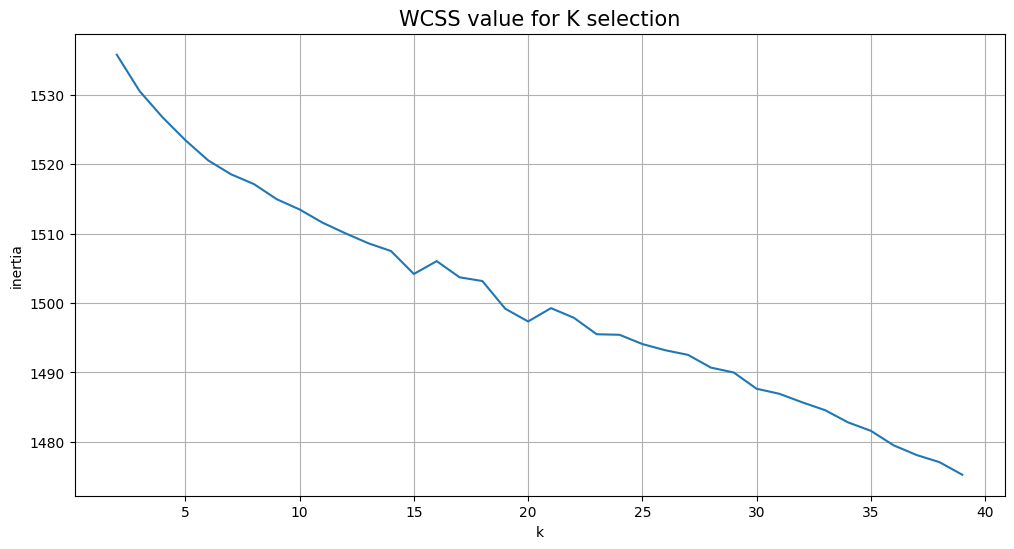

In [14]:
# Plotting the elbow curve to visually chose the k numbre
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(K_range, wcss)
plt.title("WCSS value for K selection", fontsize=15)
plt.xlabel("k", fontsize=10)
plt.ylabel("inertia", fontsize=10)
plt.grid()
plt.show()

### Clustering

In [25]:
kmeans = KMeans(
    n_clusters=4,
    random_state=42
)
cluster = kmeans.fit(X)

In [26]:
cluster

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",4
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [27]:
# Adding the cluster to df_plot
df_plot["Cluster"] = cluster.labels_

In [28]:
df_plot["Cluster"].unique()

array([3, 0, 1, 2], dtype=int32)

In [29]:
coords = pca_2d(X)


out_html = OUTPUTS / "embedding_plot_cluster.html"
plot_embeddings_2d_Clusters(df_plot, str(out_html))

print("Saved plot:", out_html)

Saved plot: /Users/jeisonroblesarias/Documents/ODSC_2026/moby-embeddings-from-stratch/outputs/embedding_plot_cluster.html


### Understanding the clusters

In [32]:
df["Cluster"] = cluster.labels_

In [34]:
df

,paragraph_id,raw_text,clean_text,char_len,word_len,Cluster
0,0,"This text is a combination of etexts, one from...",this text is a combination of etexts one from ...,342,58,3
1,1,"The pale Usher—threadbare in coat, heart, body...",the pale usher threadbare in coat heart body a...,309,57,3
2,2,"“While you take in hand to school others, and ...",while you take in hand to school others and to...,259,50,3
3,3,It will be seen that this mere painstaking bur...,it will be seen that this mere painstaking bur...,743,127,3
4,4,"So fare thee well, poor devil of a Sub-Sub, wh...",so fare thee well poor devil of a sub sub whos...,932,173,0
...,...,...,...,...,...,...
1562,1562,The harpoon was darted; the stricken whale fle...,the harpoon was darted the stricken whale flew...,480,91,1
1563,1563,"For an instant, the tranced boat’s crew stood ...",for an instant the tranced boat s crew stood s...,627,111,1
1564,1564,But as the last whelmings intermixingly poured...,but as the last whelmings intermixingly poured...,1127,197,1
1565,1565,Now small fowls flew screaming over the yet ya...,now small fowls flew screaming over the yet ya...,203,38,3


In [37]:
terms = vectorizer.get_feature_names_out()

cluster_profiles = {}

for c in sorted(df["Cluster"].unique()):
    #cluster_docs = X[df["Cluster"] == c] # Filtering the sparce matrix by each cluster
    idx = df.index[df["Cluster"] == c].to_numpy()
    cluster_docs = X[idx]

    centroid = cluster_docs.mean(axis=0)
    top_idx = np.argsort(-centroid.A1)[:12]
    top_terms = [terms[i] for i in top_idx]
    cluster_profiles[c] = top_terms

    print(f"\nCluster {c}")
    print(", ".join(top_terms))


Cluster 0
ye, ahab, thou, starbuck, stubb, man, captain, old, aye, oh, let, ll

Cluster 1
whale, sperm, sperm whale, boat, head, like, white, water, ship, whales, sea, boats

Cluster 2
queequeg, night, little, bed, thought, good, long, like, room, time, way, ship

Cluster 3
sea, whale, like, man, great, whales, ship, old, world, time, did, captain


In [38]:
df["Cluster"].value_counts().sort_index()

Cluster
0    326
1    361
2    315
3    565
Name: count, dtype: int64

In [40]:
df.groupby("Cluster")["paragraph_id"].mean()

Cluster
0    944.079755
1    898.440443
2    513.107937
3    766.769912
Name: paragraph_id, dtype: float64

In [41]:
from numpy.linalg import norm

for c in sorted(df["Cluster"].unique()):
    idx = df.index[df["Cluster"] == c].to_numpy()
    cluster_docs = X[idx]
    centroid = cluster_docs.mean(axis=0)

    distances = norm(cluster_docs - centroid, axis=1)
    print(f"Cluster {c} avg radius: {distances.mean():.4f}")

Cluster 0 avg radius: 0.9824
Cluster 1 avg radius: 0.9846
Cluster 2 avg radius: 0.9885
Cluster 3 avg radius: 0.9919


### Labeling

In [47]:
cluster_labels = {
    0 : "Dialogue & crew",
    1 : "Whales & whaling",
    2 : "Queequeg & early companionship",
    3 : "General narration"
}

df["Cluster_label"] = df["Cluster"].map(cluster_labels)
df_plot["Cluster_label"]  = df["Cluster_label"]

###  Representative paragraphs per cluster

In [48]:
for c in sorted(df["Cluster"].unique()):
    print(f"\n=== Cluster {c} : {cluster_labels[c]} ===")
    sample = df[df["Cluster"] == c].sample(2, random_state=42)
    for t in sample["raw_text"]:
        print(t[:400], "\n")


=== Cluster 0 : Dialogue & crew ===
“Avast!” cried Ahab; “let’s have fair play here, though we be the
weaker side. Yet I’ll contribute to raise rods on the Himmalehs and
Andes, that all the world may be secured; but out on privileges! Let
them be, sir.” 

“I don’t think it so strange, after all, on that account,” said Flask.
“If his leg were off at the hip, now, it would be a different thing.
That would disable him; but he has one knee, and good part of the other
left, you know.” 


=== Cluster 1 : Whales & whaling ===
In good time, Flask’s saying proved true. As before, the Pequod steeply
leaned over towards the sperm whale’s head, now, by the counterpoise of
both heads, she regained her even keel; though sorely strained, you may
well believe. So, when on one side you hoist in Locke’s head, you go
over that way; but now, on the other side, hoist in Kant’s and you come
back again; but in very poor plight. Thus,  

BOOK II. (_Octavo_), CHAPTER I. (_Grampus_).—Though this fish, whose
lo